# eda006
移動を確認(kalmanスムーザ後)

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px

# utils

In [2]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [3]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [4]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['latDeg_gt_prev'] = df['latDeg_gt'].shift(1)
    df['latDeg_gt_next'] = df['latDeg_gt'].shift(-1)
    df['lngDeg_gt_prev'] = df['lngDeg_gt'].shift(1)
    df['lngDeg_gt_next'] = df['lngDeg_gt'].shift(-1)    
    
    df['latDeg_prev_diff'] = df['latDeg'] - df['latDeg_prev']
    df['latDeg_next_diff'] = df['latDeg_next'] - df['latDeg']
    df['latDeg_gt_prev_diff'] = df['latDeg_gt'] - df['latDeg_gt_prev']
    df['latDeg_gt_next_diff'] = df['latDeg_gt_next'] - df['latDeg_gt']
    
    df['lngDeg_prev_diff'] = df['lngDeg'] - df['lngDeg_prev']
    df['lngDeg_next_diff'] = df['lngDeg_next'] - df['lngDeg']
    df['lngDeg_gt_prev_diff'] = df['lngDeg_gt'] - df['lngDeg_gt_prev']
    df['lngDeg_gt_next_diff'] = df['lngDeg_gt_next'] - df['lngDeg_gt']
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df['dist_gt_prev'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_prev'], df['lngDeg_gt_prev'])
    df['dist_gt_next'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_next'], df['lngDeg_gt_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev', 'latDeg_gt_prev', 'lngDeg_gt_prev', 'dist_gt_prev', 
                                           'latDeg_prev_diff', 'latDeg_gt_prev_diff', 'lngDeg_prev_diff', 'lngDeg_gt_prev_diff']] = np.nan
    
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next', 'latDeg_gt_next', 'lngDeg_gt_next', 'dist_gt_next',
                                           'latDeg_next_diff', 'latDeg_gt_next_diff', 'lngDeg_next_diff', 'lngDeg_gt_next_diff']] = np.nan
    
    return df

# data prep

In [5]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [6]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

In [7]:
train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')

In [8]:
# ground_truth
p = pathlib.Path(INPUT)
gt_files = list(p.glob('train/*/*/ground_truth.csv'))
print('ground_truth.csv count : ', len(gt_files))

gts = []
for gt_file in tqdm(gt_files):
    gts.append(pd.read_csv(gt_file))
ground_truth = pd.concat(gts)

display(ground_truth.head())

ground_truth.csv count :  73


  0%|          | 0/73 [00:00<?, ?it/s]

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
0,2020-05-21-US-MTV-2,Pixel4,1274131364434,37.628927,-122.426295,65.36,64.43,2.6,0.0,0.0,154.3
1,2020-05-21-US-MTV-2,Pixel4,1274131365434,37.628927,-122.426295,65.36,65.43,2.6,0.0,0.0,154.3
2,2020-05-21-US-MTV-2,Pixel4,1274131366434,37.628927,-122.426295,65.36,66.43,2.6,0.0,0.0,154.3
3,2020-05-21-US-MTV-2,Pixel4,1274131367434,37.628927,-122.426295,65.36,67.43,2.6,0.0,0.0,154.3
4,2020-05-21-US-MTV-2,Pixel4,1274131368434,37.628927,-122.426295,65.36,68.43,2.6,0.0,0.0,154.3


In [9]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [11]:
# reject outlier
train_ro = add_distance_diff(train)
th = 50
train_ro.loc[((train_ro['dist_prev'] > th) & (train_ro['dist_next'] > th)), ['latDeg', 'lngDeg']] = np.nan

In [12]:
import simdkalman

In [13]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [14]:
cols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']
train_ro_kf = apply_kf_smoothing(train_ro[cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [17]:
def add_distance_diff2(df):
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['latDeg_gt_prev'] = df['latDeg_gt'].shift(1)
    df['latDeg_gt_next'] = df['latDeg_gt'].shift(-1)
    df['lngDeg_gt_prev'] = df['lngDeg_gt'].shift(1)
    df['lngDeg_gt_next'] = df['lngDeg_gt'].shift(-1)    
    
    df['latDeg_prev_diff'] = df['latDeg'] - df['latDeg_prev']
    df['latDeg_next_diff'] = df['latDeg_next'] - df['latDeg']
    df['latDeg_gt_prev_diff'] = df['latDeg_gt'] - df['latDeg_gt_prev']
    df['latDeg_gt_next_diff'] = df['latDeg_gt_next'] - df['latDeg_gt']
    
    df['lngDeg_prev_diff'] = df['lngDeg'] - df['lngDeg_prev']
    df['lngDeg_next_diff'] = df['lngDeg_next'] - df['lngDeg']
    df['lngDeg_gt_prev_diff'] = df['lngDeg_gt'] - df['lngDeg_gt_prev']
    df['lngDeg_gt_next_diff'] = df['lngDeg_gt_next'] - df['lngDeg_gt']
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df['dist_gt_prev'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_prev'], df['lngDeg_gt_prev'])
    df['dist_gt_next'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_next'], df['lngDeg_gt_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev', 'latDeg_gt_prev', 'lngDeg_gt_prev', 'dist_gt_prev', 
                                           'latDeg_prev_diff', 'latDeg_gt_prev_diff', 'lngDeg_prev_diff', 'lngDeg_gt_prev_diff']] = np.nan
    
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next', 'latDeg_gt_next', 'lngDeg_gt_next', 'dist_gt_next',
                                           'latDeg_next_diff', 'latDeg_gt_next_diff', 'lngDeg_next_diff', 'lngDeg_gt_next_diff']] = np.nan
    
    return df

In [18]:
ground_truth = ground_truth.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt', 'heightAboveWgs84EllipsoidM':'heightAboveWgs84EllipsoidM_gt'})

train = train_ro_kf.merge(ground_truth, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')





train = add_distance_diff2(train)

# 具体例で

In [19]:
df = train[train['phone']=='2020-05-14-US-MTV-1_Pixel4XLModded'].copy().reset_index(drop=True)

In [20]:
df.columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg',
       'lngDeg', 'latDeg_gt', 'lngDeg_gt', 'heightAboveWgs84EllipsoidM_gt',
       'timeSinceFirstFixSeconds', 'hDop', 'vDop', 'speedMps', 'courseDegree',
       'phone', 'latDeg_prev', 'latDeg_next', 'lngDeg_prev', 'lngDeg_next',
       'phone_prev', 'phone_next', 'latDeg_gt_prev', 'latDeg_gt_next',
       'lngDeg_gt_prev', 'lngDeg_gt_next', 'latDeg_prev_diff',
       'latDeg_next_diff', 'latDeg_gt_prev_diff', 'latDeg_gt_next_diff',
       'lngDeg_prev_diff', 'lngDeg_next_diff', 'lngDeg_gt_prev_diff',
       'lngDeg_gt_next_diff', 'dist_prev', 'dist_next', 'dist_gt_prev',
       'dist_gt_next'],
      dtype='object')

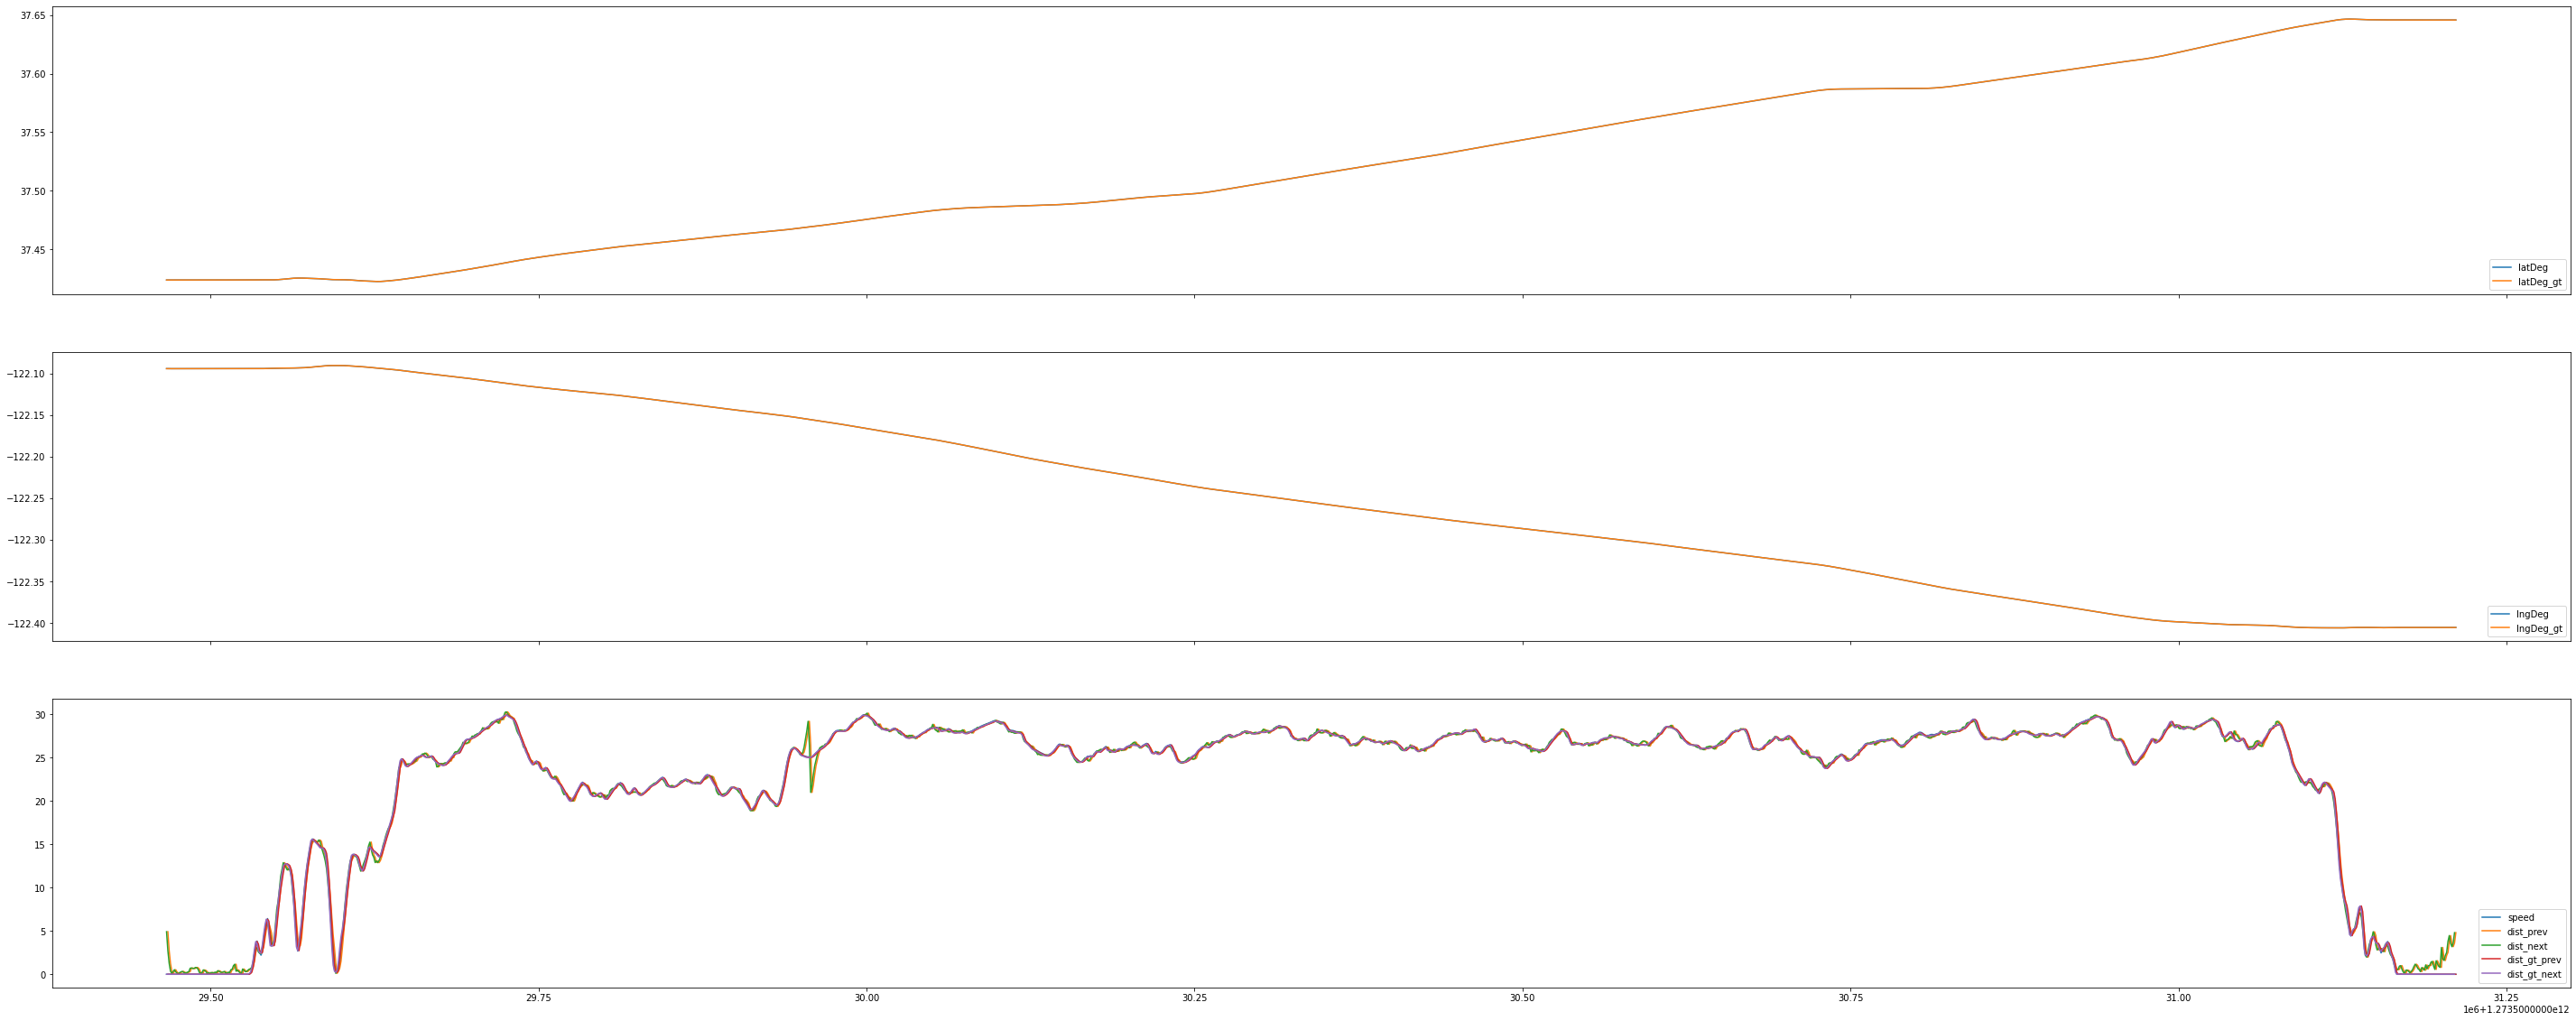

In [21]:
fig, axes = plt.subplots(figsize=(50, 20), nrows=3,sharex=True)

axes[0].plot(df['millisSinceGpsEpoch'], df['latDeg'], label='latDeg')
axes[0].plot(df['millisSinceGpsEpoch'], df['latDeg_gt'], label='latDeg_gt')
axes[1].plot(df['millisSinceGpsEpoch'], df['lngDeg'], label='lngDeg')
axes[1].plot(df['millisSinceGpsEpoch'], df['lngDeg_gt'], label='lngDeg_gt')
axes[2].plot(df['millisSinceGpsEpoch'], df['speedMps'], label='speed')
axes[2].plot(df['millisSinceGpsEpoch'], df['dist_prev'], label='dist_prev')
axes[2].plot(df['millisSinceGpsEpoch'], df['dist_next'], label='dist_next')
axes[2].plot(df['millisSinceGpsEpoch'], df['dist_gt_prev'], label='dist_gt_prev')
axes[2].plot(df['millisSinceGpsEpoch'], df['dist_gt_next'], label='dist_gt_next')
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')

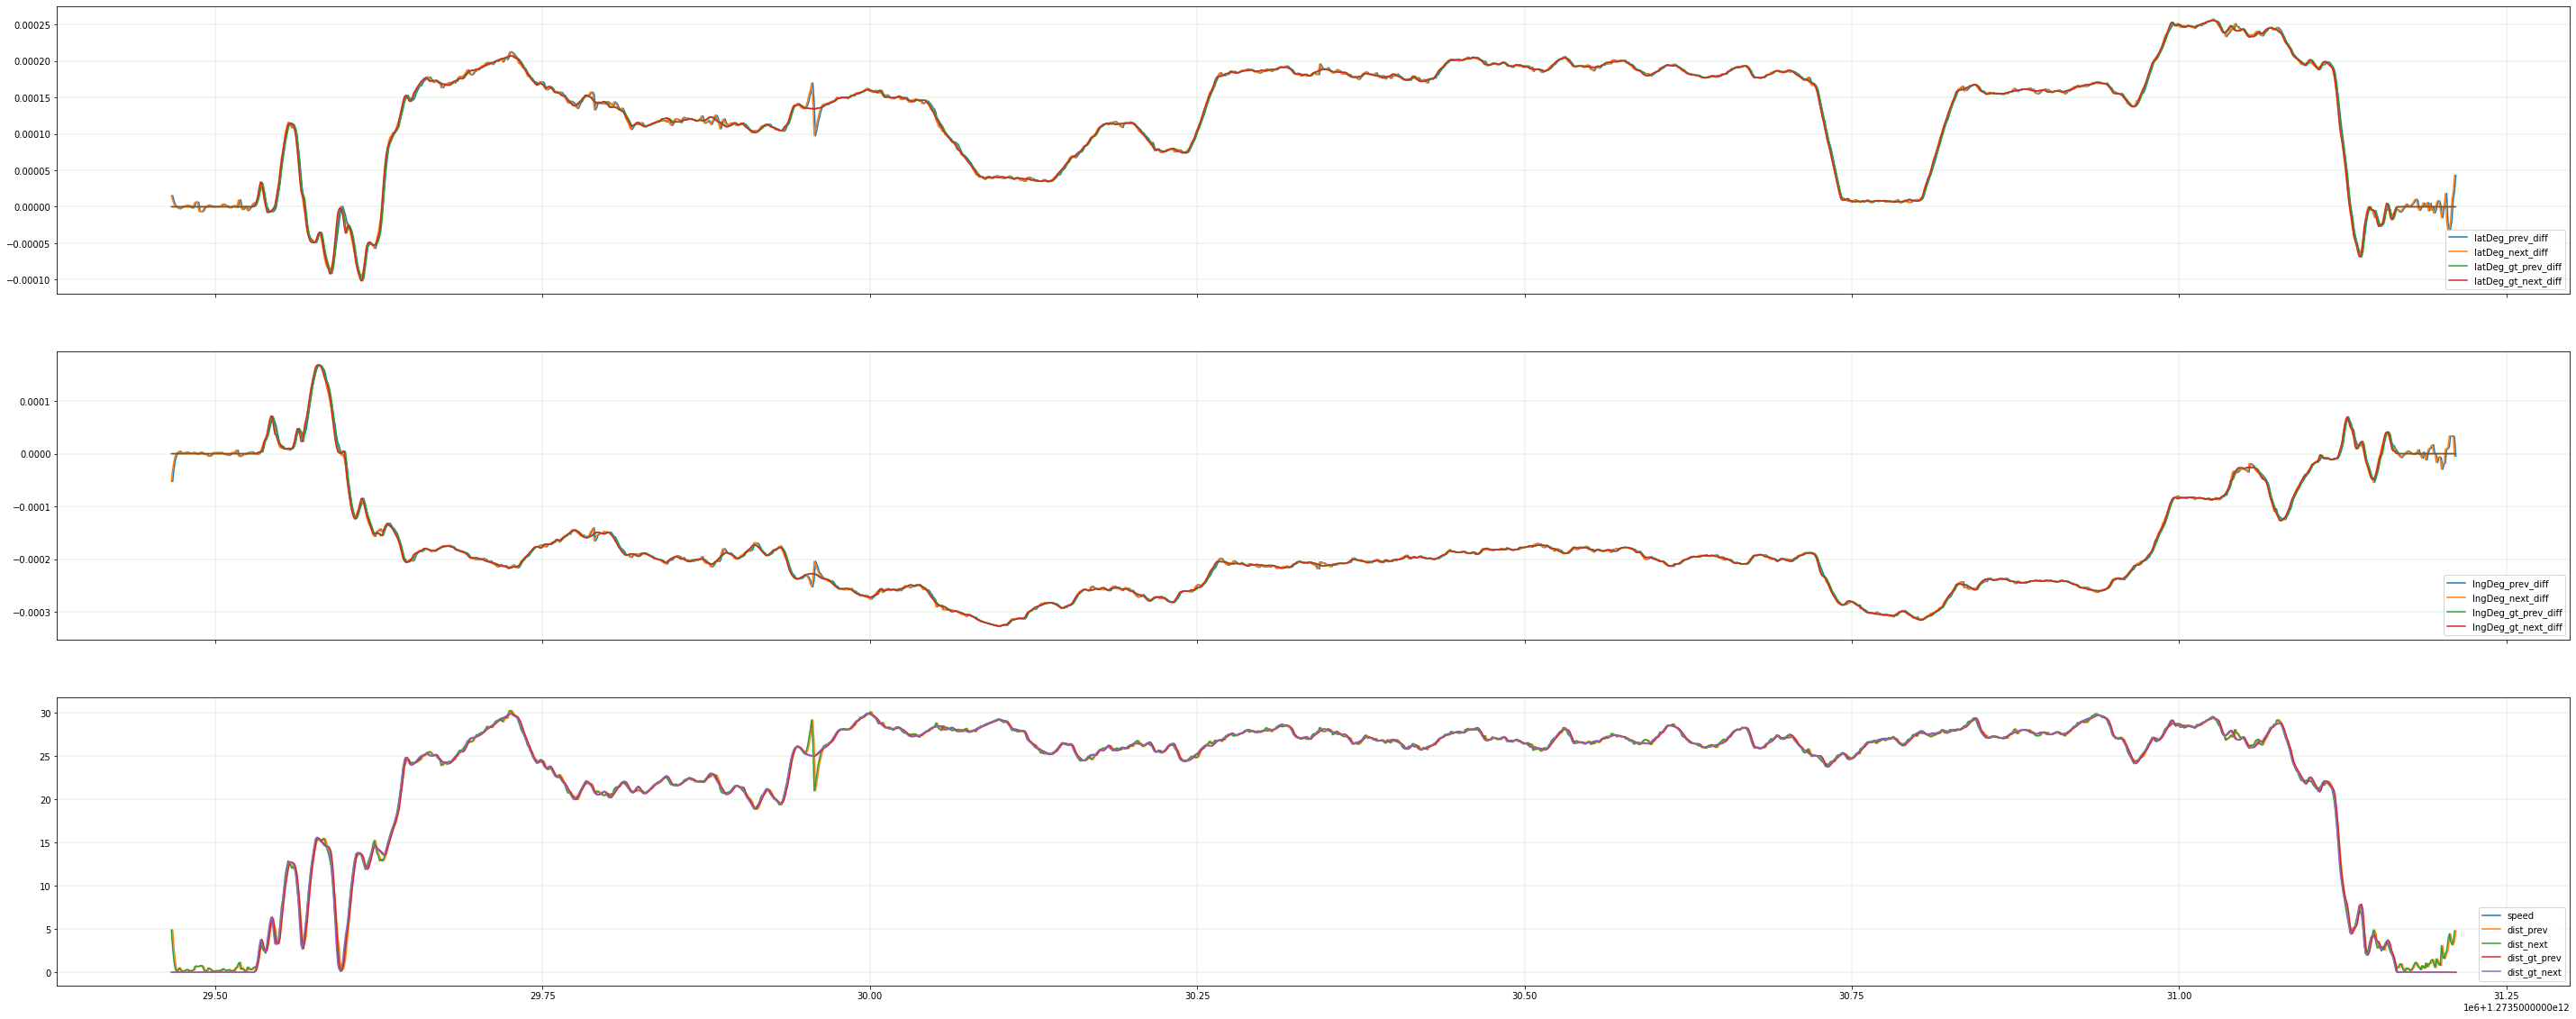

In [22]:
fig, axes = plt.subplots(figsize=(50, 20), nrows=3,sharex=True)

axes[0].plot(df['millisSinceGpsEpoch'], df['latDeg_prev_diff'], label='latDeg_prev_diff')
axes[0].plot(df['millisSinceGpsEpoch'], df['latDeg_next_diff'], label='latDeg_next_diff')
axes[0].plot(df['millisSinceGpsEpoch'], df['latDeg_gt_prev_diff'], label='latDeg_gt_prev_diff')
axes[0].plot(df['millisSinceGpsEpoch'], df['latDeg_gt_next_diff'], label='latDeg_gt_next_diff')

axes[1].plot(df['millisSinceGpsEpoch'], df['lngDeg_prev_diff'], label='lngDeg_prev_diff')
axes[1].plot(df['millisSinceGpsEpoch'], df['lngDeg_next_diff'], label='lngDeg_next_diff')
axes[1].plot(df['millisSinceGpsEpoch'], df['lngDeg_gt_prev_diff'], label='lngDeg_gt_prev_diff')
axes[1].plot(df['millisSinceGpsEpoch'], df['lngDeg_gt_next_diff'], label='lngDeg_gt_next_diff')

axes[2].plot(df['millisSinceGpsEpoch'], df['speedMps'], label='speed')
axes[2].plot(df['millisSinceGpsEpoch'], df['dist_prev'], label='dist_prev')
axes[2].plot(df['millisSinceGpsEpoch'], df['dist_next'], label='dist_next')
axes[2].plot(df['millisSinceGpsEpoch'], df['dist_gt_prev'], label='dist_gt_prev')
axes[2].plot(df['millisSinceGpsEpoch'], df['dist_gt_next'], label='dist_gt_next')
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
axes[0].grid(color='g', linestyle=':', linewidth=0.3)
axes[1].grid(color='g', linestyle=':', linewidth=0.3)
axes[2].grid(color='g', linestyle=':', linewidth=0.3)

In [24]:
phones = train_ro['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=3,sharex=True)
    tmp = train[train['phone']==phone].copy()

    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg_prev_diff'], label='latDeg_prev_diff')
    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg_next_diff'], label='latDeg_next_diff')
    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg_gt_prev_diff'], label='latDeg_gt_prev_diff')
    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg_gt_next_diff'], label='latDeg_gt_next_diff')

    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg_prev_diff'], label='lngDeg_prev_diff')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg_next_diff'], label='lngDeg_next_diff')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg_gt_prev_diff'], label='lngDeg_gt_prev_diff')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg_gt_next_diff'], label='lngDeg_gt_next_diff')

    axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['speedMps'], label='speed')
    axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['dist_prev'], label='dist_prev')
    axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['dist_next'], label='dist_next')
    axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['dist_gt_prev'], label='dist_gt_prev')
    axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['dist_gt_next'], label='dist_gt_next')
    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    axes[2].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    axes[2].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/dist_diff/train/' + phone + '.png')
    plt.close()